# UMA Projekt
### Miłosz Cieśla, Filip Ryniewicz

## Temat projektu
Zaimplementuj techniki oceny klasyfikacji dla zestawów danych dotyczących raka piersi, które dostępne są w http://archive.ics.uci.edu/ml/datasets

## Streszczenie założeń
Zdecydowaliśmy się przeprowadzić eksperymenty z użyciem trzech modeli:
- Wielowarstwowego perceptronu,
- Algorytmu K-Najbliższych Sąsiadów,
- Lasu Losowego.

Na podstawie analizy wykresów zależności między hiperparametrami a współczynnikiem błędu dobraliśmy optymalne wartości parametrów dla każdego modelu. Dokonaliśmy również analizy czasów trenowania i predykcji, uwzględniając trzy najlepsze konfiguracje parametrów dla każdego z nich.

Zaimplementowaliśmy osiem metod oceny jakości klasyfikacji i przeanalizowaliśmy wzajemne zależności między otrzymanymi miarami.

## Opis funkcjonalny
### Modele
Wszystkie modele zostały zaimplementowane zgodnie z wcześniej utworzonym przez nas interfejsem znajdującym się w pliku 'models.py', co znacznie ułatwiło nam przeprowadzenie wszystkich eksperymentów. Mogliśmy wykorzystać wspólne funkcje do wykonania pomiarów oraz pozwoliło nam to na unifikację przyjmowanych danych oraz argumentów.
Opis modeli: 
- **Wielowarstwowy perceptron MLP** został zaimplementowany z użyciem biblioteki pytorch. Składa się on z 4 warstw:
    - wejściowej (64 neurony),
    - ukrytej 1 (64 neurony)
    - ukrytej 2 (32 neurony)
    - wyjściowej (1 neuron).

    Zgodnie z założeniami wstępnymi, jako funkcję aktywacji w warstwach ukrytych użyliśmy ReLU, natomiast w warstwie wyjściowej sigmoid.
    Istotną zaletą, którą udało nam się zauważyć dla ReLU jest jego wydajność, pozwoliło nam to na osiągnięcie czasów trenowania oraz predykcji które znacząco nie spowolniły nasze eksperymenty oraz zachowały wysoką skuteczność, natomiast warstwa wyjściowa używa sigmoidu, aby zachować wyniki w zakresie od [0, 1].
    Podczas propagacji wstecznej używamy binarnej entropii krzyżowej do obliczenia wartości funkcji straty. Wybraliśmy ją ze względu na czułość na różnice w zakresie wartości prawdopodobieństw otrzymanych od sigmoidu.
    Po obliczeniu funkcji straty używamy optymalizatora Adam w celu jej minimalizacji, aktualizacji wag sieci oraz zapobiegania przeuczeniu.

- **Algorytm K-Najlbliższych sąsiadów KNN** został zaimplementowany z użyciem biblioteki scikit-learn. Jedynym parametrem który mogliśmy dostosować jest liczba sąsiadów. Jest to najprostszy z modeli używanych w naszych eksperymentach.
- **Las losowy** został również zaimplementowany przy użyciu biblioteki scikit-learn. Zdecydowaliśmy się na niego ponieważ jest on skuteczny do złożonych zadań klasyfikacyjnych, szczególnie gdy dane zawierają dużą liczbę cech. Przed przystąpieniem do eksperymentów nie byliśmy w stanie dokładnie ocenić jakości zestawu danych, dlatego odporność tego modelu na szum stanowiła dla nas dodatkowy atut.

## Zaimplementowane metody oceny klasyfikacji
1. **Error Rate**
   - **Opis**: Odsetka błędnych predykcji w klasyfikacji. Mówi, jak często klasyfikator popełnia błędy, czyli jak wiele przypadków jest błędnie sklasyfikowanych.
   - **Wzór**:
      $\text{Error Rate} = \frac{\text{Liczba błędnych predykcji}}{\text{Całkowita liczba próbek}}$

2. **Accuracy**
   - **Opis**: Odsetka poprawnych predykcji. Określa, jak skutecznie klasyfikator w przewidywaniu poprawnych wyników. Może być myląca w przypadku nierównych klas.
   - **Wzór**:
     $\text{Accuracy} = \frac{\text{Liczba poprawnych predykcji}}{\text{Całkowita liczba próbek}}$

3. **True Positive Rate (TPR)**
   - **Opis**: Wskaźnik czułości, czyli stosunek liczby prawdziwych pozytywów (TP) do sumy prawdziwych pozytywów (TP) i fałszywych negatywów (FN).
   - **Wzór**:
     $\text{True Positive Rate (TPR)} = \frac{TP}{TP + FN}$

4. **False Positive Rate (FPR)**
   - **Opis**: Wskaźnik fałszywych pozytywów, czyli stosunek liczby fałszywych pozytywów (FP) do sumy fałszywych pozytywów (FP) i prawdziwych negatywów (TN).
   - **Wzór**:
     $\text{False Positive Rate (FPR)} = \frac{FP}{FP + TN}$

5. **Precision**
   - **Opis**: Miara precyzji, czyli stosunek liczby prawdziwych pozytywów (TP) do sumy prawdziwych (TP) i fałszywych pozytywów (FP).
   - **Wzór**:
     $\text{Precision} = \frac{TP}{TP + FP}$

6. **F1 Score**
   - **Opis**: Miara harmonicznego średniego precyzji (Precision) i True Positive Rate. Jest to ważna miara, gdy zależy nam na balansie między precyzją a czułością.
   - **Wzór**:
     $\text{F1} = \frac{2 \times \text{Precision} \times \text{TPR}}{\text{Precision} + \text{TPR}}$

7. **ROC Curve**
   - **Opis**: Krzywa ROC (Receiver Operating Characteristic) ilustruje zależność między TPR a FPR dla różnych progów decyzyjnych. Przedstawia, jak zmienia się skuteczność klasyfikatora w zależności od ustawienia progu.

8. **AUC-ROC Score**
   - **Opis**: Pole pod krzywą ROC (Area Under the Curve), które mierzy ogólną skuteczność klasyfikatora. Im wyższa wartość AUC, tym lepszy jest klasyfikator w rozróżnianiu pozytywnych i negatywnych próbek.

### Potrzebne importy

In [1]:
import sys
sys.path.append('../')

from models.knn import KNN
from models.mlp import MLP
from models.random_forest import RandomForest
from utils import *
from eval_techniques import *
from time import perf_counter
import numpy as np
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
import torch
import pandas as pd
import heapq


## Przygotowanie danych

Pobieramy zbiór danych z użyciem biblioteki ucimlrepo. Następnie dzielimy go na zbiory cech i etykiety, zmieniając ich typ na `np.array`. Oryginalnie etykiety są ze zbioru {"M", "B"}, lecz przekonwertowaliśmy je na wartości boolowskie, świadczące o złośliwości komórek rakowych.

In [2]:
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

X = breast_cancer_wisconsin_diagnostic.data.features
X = np.array(X.values)
Y = np.array(breast_cancer_wisconsin_diagnostic.data.targets.Diagnosis)
Y = Y == "M"

## Dobór hiperparametrów

Napisaliśmy funkcję `compare_hyperparams`, która uruchamia k-krotną walidację krzyżową dla modeli o kolejnych wartościach badanego hiperparametru, po czym uśrednia uzyskane wyniki, w celu przybliżenia faktycznej wartości rzeczywistej błędu na zbiorze testowym.

### Perceptron wielowarstwowy

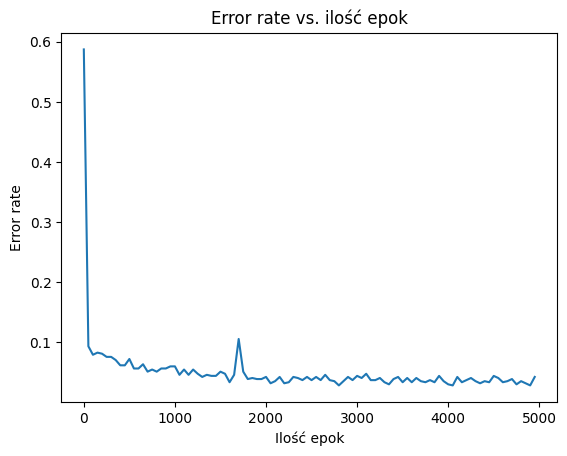

,Ilość epok,Error rate
0,4051,[0.0281328320802005]
1,2801,[0.028164160401002503]
2,4901,[0.028164160401002503]


In [3]:
epoch_lens = np.array(range(1, 5000)[::50])
error_rates = compare_hyperparams(MLP, epoch_lens, X, Y)

plt.plot(epoch_lens, error_rates)
plt.xlabel("Ilość epok")
plt.ylabel("Error rate")
plt.title("Error rate vs. ilość epok")
plt.show()

mlp_best_params = heapq.nsmallest(3, zip(epoch_lens, error_rates), key=lambda x: x[1])
df = pd.DataFrame(mlp_best_params, columns=["Ilość epok", "Error rate"])
df

W przypadku MLP, zdecydowaliśmy się dostosowywać tylko ilość epok. Założyliśmy, że pozostałe parametry takie jak ilość i rozmiar warstw są odpowiednie dla wybranego zbioru danych.

W początkowej fazie dobierania liczby epok trenowania, rozpatrywaliśmy wartości mniejsze niż 100. Z kształtu wykresu wywnioskowaliśmy, że error rate obniżą się dla jeszcze większych wartości i faktycznie tak było. 

Zdziwiliśmy się, że dla tak dużych ilości epok nie dochodzi do przeuczenia. Jednak, doszliśmy do wniosku, że nasza implementacja MLP potrafi radzić sobie z dużą liczbą epok treningowych, z uwagi na wbudowany optymalizator Adam, który pomaga zapobiegać przeuczeniu. Dodatkowo, MLP uczą się bardziej złożonych reprezentacji danych, co pozwala im lepiej generalizować i wykorzystywać więcej epok bez utraty zdolności do przewidywania na nowych danych.

Najlepsze wartości parametru, które udało nam się znaleźć są przedstawione w powyższej tabelce.

## K najbliższych sąsiadów

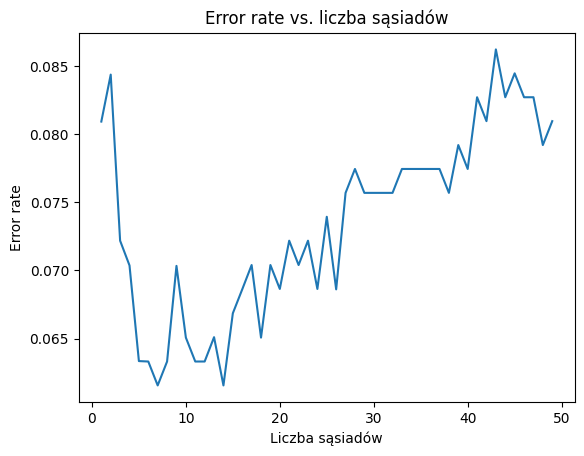

,Liczba sąsiadów,Error rate
0,7,[0.06156015037593985]
1,14,[0.06156015037593985]
2,6,[0.06331453634085213]


In [4]:
n_neighbors_list = list(range(1, 50))
error_rates = compare_hyperparams(KNN, n_neighbors_list, X, Y)

plt.plot(n_neighbors_list, error_rates)
plt.xlabel("Liczba sąsiadów")
plt.ylabel("Error rate")
plt.title("Error rate vs. liczba sąsiadów")
plt.show()

knn_best_params = heapq.nsmallest(3, zip(n_neighbors_list, error_rates), key=lambda x: x[1])
df = pd.DataFrame(knn_best_params, columns=["Liczba sąsiadów", "Error rate"])
df

Algorytm k-najbliższych sąsiadów może się przeuczyć, gdy parametr n_neighbors jest ustawiony na zbyt dużą wartość. Zbyt duża liczba sąsiadów powoduje, że algorytm zaczyna brać pod uwagę zbyt dużą część zbioru danych przy klasyfikacji punktu. Model zaczyna traktować zbyt wiele punktów jako potencjalnych sąsiadów, co prowadzi do zbyt ogólnych przewidywań. Zbyt duża wartość n_neighbors może więc skutkować wyższym błędem na zbiorze testowym.

Z tego powodu najlepsze wartości error_rate zwykle osiąga się dla niższych wartości n_neighbors. Optymalne wartości n_neighbors znajdują się w powyższej tabelce.

## Las losowy

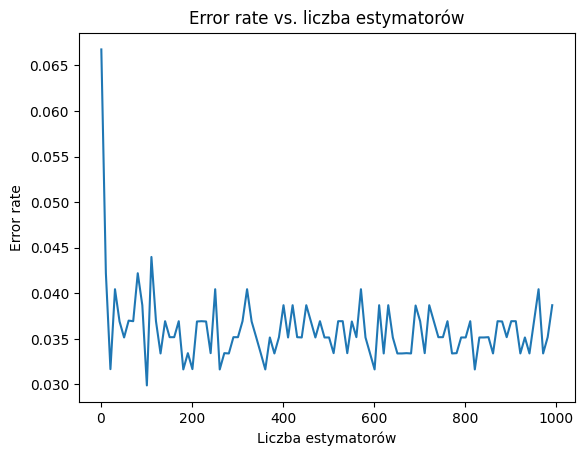

,Liczba estymatorów,Error rate
0,101,[0.029887218045112778]
1,181,[0.03164160401002506]
2,261,[0.03164160401002506]


In [5]:
n_estimators_list = list(range(1, 1000)[::10])
error_rates = compare_hyperparams(RandomForest, n_estimators_list, X, Y)

plt.plot(n_estimators_list, error_rates)
plt.xlabel("Liczba estymatorów")
plt.ylabel("Error rate")
plt.title("Error rate vs. liczba estymatorów")
plt.show()

rf_best_params = heapq.nsmallest(3, zip(n_estimators_list, error_rates), key=lambda x: x[1])
df = pd.DataFrame(rf_best_params, columns=["Liczba estymatorów", "Error rate"])
df

Wykres zależności liczby estymatorów (drzew) od błędu w lesie losowym jest bardzo skokowy, ponieważ randomizacja w losowym doborze cech przy tworzeniu każdego drzewa prowadzi do dużych wahań w błędzie modelu. 

Liczba estymatorów wpływa na stabilność predykcji, ale ze względu na losowość w procesie uczenia, możliwe jest występowanie lokalnych minimów błędu, co powoduje, że wykres ma charakter "kolców".

Z uwagi na to, możliwe jest, że w innych uruchomieniach powyższej komórki wyszłyby zupełnie inne wartości optymalne hiperparametru.

## Analiza czasów trenowania i predykcji modeli

Zmierzyliśmy czasy trenowania modeli, uwzględniając optymalne wartości hiperparametrów uzyskane wcześniej. Dodatkowo, przeprowadziliśmy eksperyment dotyczący czasów predykcji, zakładając, że będą one niezależne od wartości parametrów, które mają głównie wpływ na czas trenowania.

### Podział na Zbiór treningowy i testowy

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=42)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

### Mierzenie czasów

W celu ułatwienia tego eksperymentu napisaliśmy funkcję `measure_times`, która trenuje model i wykonuję predykcję na zbiorze testowym zadaną ilość razy (bazowo 50), zwracając średnią ze zmierzonych czasów.

In [7]:
mlp_train_times, mlp_predict_times = measure_times(MLP, mlp_best_params, X_train_tensor, y_train_tensor, X_test_tensor)
knn_train_times, knn_predict_times = measure_times(KNN, knn_best_params, X_train, y_train, X_test)
rf_train_times, rf_predict_times = measure_times(RandomForest, rf_best_params, X_train, y_train, X_test)

### Wyniki

In [16]:
rows = []

for param, train_time, predict_time in zip(mlp_best_params, mlp_train_times, mlp_predict_times):
    rows.append({"model": "MLP", "param": param[0], "train_time": train_time, "predict_time": predict_time})

for param, train_time, predict_time in zip(knn_best_params, knn_train_times, knn_predict_times):
    rows.append({"model": "KNN", "param": param[0], "train_time": train_time, "predict_time": predict_time})

for param, train_time, predict_time in zip(rf_best_params, rf_train_times, rf_predict_times):
    rows.append({"model": "Random Forest", "param": param[0], "train_time": train_time, "predict_time": predict_time})

df = pd.DataFrame(rows, index=["" for _ in range(len(rows))])
df

,model,param,train_time,predict_time
,MLP,4051,0.814690,0.000074
,MLP,2801,0.568159,0.000067
,MLP,4901,0.984672,0.000075
,KNN,7,0.000331,0.002530
,KNN,14,0.000252,0.000864
,KNN,6,0.000166,0.000436
,Random Forest,101,0.057724,0.002336
,Random Forest,181,0.100551,0.003819
,Random Forest,261,0.140207,0.005465


### Analiza wyników:
- MLP: Czas treningu wzrasta wraz ze wzrostem ilości epok. Czas predykcji pozostaje na bardzo niskim poziomie, niezależnie od parametru.
- KNN: Dla tego modelu, im więcej sąsiadów, tym dłuższy czas predykcji. Czas treningu w tym przypadku jest bardzo niski, co jest charakterystyczne dla algorytmu KNN, który nie wymaga fazy treningu w tradycyjnym sensie (model nie “uczy się” na danych, tylko przechowuje je).
- Random Forest: Czas treningu wzrasta proporcjonalnie do liczby drzew w lesie, co jest zgodne z oczekiwaniami, ponieważ więcej drzew oznacza większą złożoność obliczeniową. Czas predykcji również wzrasta, ale nie tak znacząco jak czas treningu.

## Porównanie modeli na podstawie wybranych miar klasyfikacji

W celu efektywnej realizacji tego eksperymentu, zaimplementowaliśmy 2 funkcje:
- `kfold_cv` - obudowana k-krotna walidacja krzyżowa pozwalająca na jednoczesne obliczenie wartości wszystkich zaimplementowanych miar liczbowych oceny klasyfikacji modelu.
- `compare_models` - korzystając z `kfold_cv` generuje sformatowane dane potrzebne do analizy.

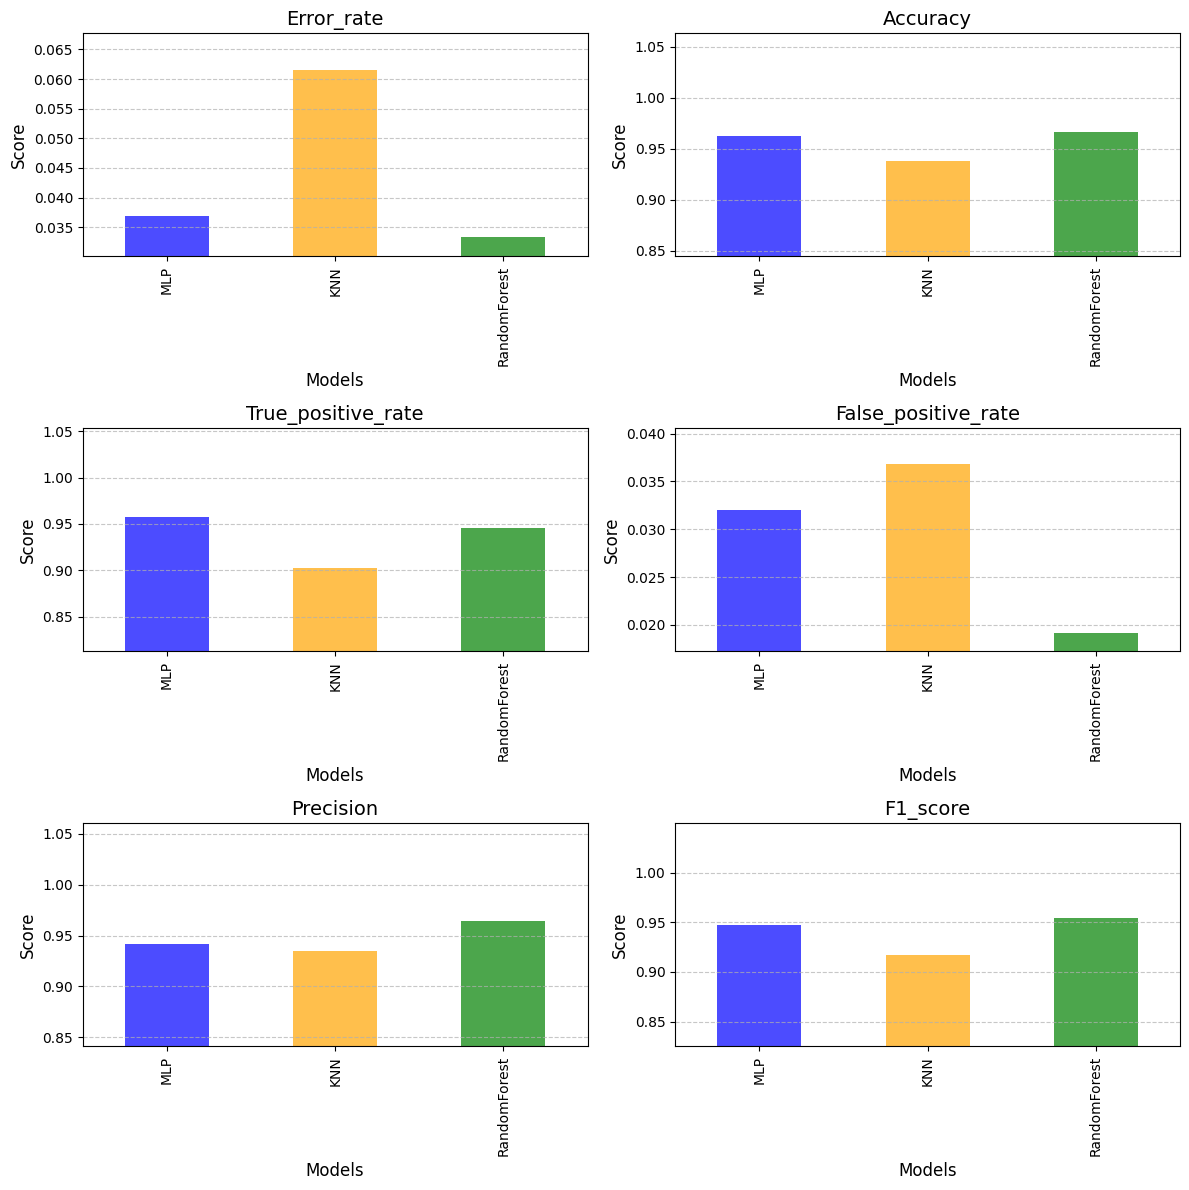

,MLP,KNN,RandomForest
error_rate,0.036967,0.061560,0.033396
accuracy,0.963033,0.938440,0.966604
true_positive_rate,0.957377,0.902541,0.945798
false_positive_rate,0.032013,0.036873,0.019118
precision,0.941255,0.934520,0.963848
f1_score,0.947719,0.916586,0.954190


In [11]:
# params = [mlp_best_params[0][0], knn_best_params[0][0], rf_best_params[0][0]]
params = [3901, 7, 3901]
model_classess = [MLP, KNN, RandomForest]
models_evals = compare_models(model_classess, params, X, Y)
df = pd.DataFrame(models_evals)

num_metrics = df.index.size
nrows, ncols = 3, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12), sharex=False)
axes = axes.flatten()

for idx, metric in enumerate(df.index):
    if idx < len(axes):
        ax = axes[idx]
        bars = df.loc[metric].plot(kind='bar', ax=ax, color=['blue', 'orange', 'green'], alpha=0.7)
        ax.set_title(metric.capitalize(), fontsize=14)
        ax.set_ylabel("Score", fontsize=12)
        ax.set_xlabel("Models", fontsize=12)
        ax.grid(axis='y', linestyle='--', alpha=0.7)

        max_height = max(bar.get_height() for bar in bars.patches)
        min_height = min(bar.get_height() for bar in bars.patches)
        ax.set_ylim(0.9 * min_height, 1.1 * max_height)

for ax in axes[len(df.index):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

df

### Krzywe ROC

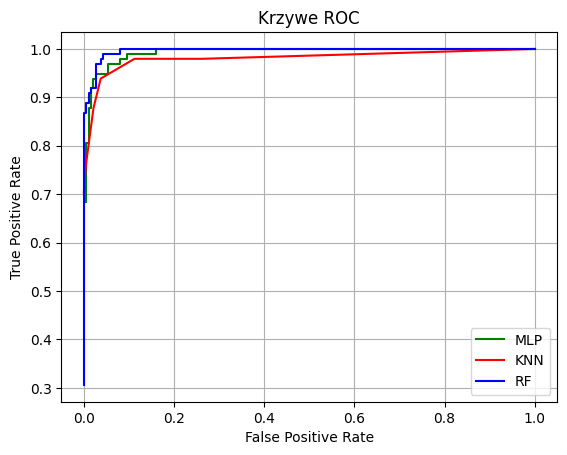

In [ ]:
params = [mlp_best_params[0][0], knn_best_params[0][0], rf_best_params[0][0]]
plot_roc_curve([MLP, KNN, RandomForest], params, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor)